# Linear Regression
### Type: Testing notebook
Should read again the Statistics book from university, the basics and foundations from this chapter are actually there.\
While reading the chapter, I wanted to try and get a linear regression working before reading it.\
Then, thinking about possible cool projects, I stepped across the idea of evaluating the performance of a linear regression for predictions in the stock market, seeing how does it perform, and whether it is feasible as algorithm (I can already guess the answer...), but seems like a cool project.

We first need to import the following data science libraries:

In [6]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

Now I have to import the **Yahoo Finance API** for getting stock market data and mpfinance for conviniently plotting candlestick charts:

In [7]:
import yfinance as yf
import mplfinance as mpf

Now I use the yfinance API for requesting data from the stock market. Let's try with the AAPL ticker symbol (for Apple), in the period of 1 year to extract the tendency of Apple's stock (whether it keeps growing or not).

***
## Data cleanup and treatment
Always remember the cliché *"garbage in, garbage out"*...

In [27]:
# Select the symbols
ticker_symbols = ["AAPL"]

# Create a Ticker object
data = yf.download(ticker_symbols, start="2024-07-19",end="2024-12-28", auto_adjust=True)
data_backup = data
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2024-07-19  223.265869  225.744284  222.240665  223.773505  49151500
2024-07-22  222.917496  226.719706  222.051535  225.953286  48201800
2024-07-23  223.962601  225.883625  221.643445  223.325580  39960300
2024-07-24  217.522705  223.753575  216.119280  222.957296  61777600
2024-07-25  216.477600  219.821960  213.620949  217.910884  51391200


I'll just create a simple candlestick chart for visualizing the dataset we are using. Keep in mind that although I'll plot all the prices now, I will not be using all that information, only the close prices and the price ticker date. ***DO NOT EXECUTE IF TRYING TO EXECUTE MORE CELLS***.

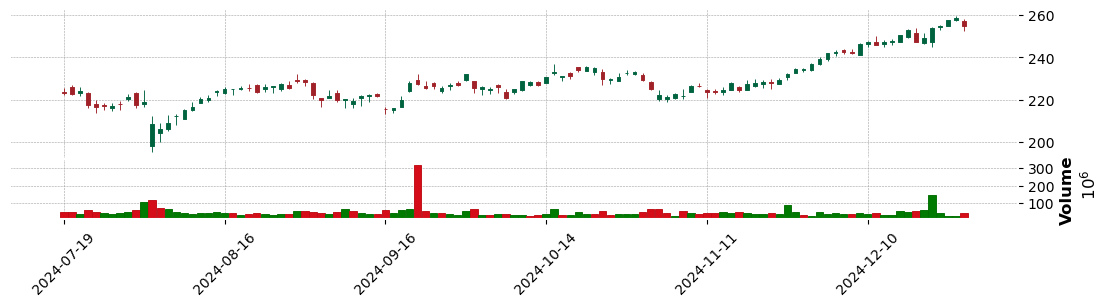

In [26]:
# Convert 'Date' column to pandas datetime format
data.index = pd.to_datetime(data.index)

data.columns = [col[0] for col in data.columns]

data['Open'] = pd.to_numeric(data['Open'], errors='coerce')
data['High'] = pd.to_numeric(data['High'], errors='coerce')
data['Low'] = pd.to_numeric(data['Low'], errors='coerce')
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

data.dropna(subset=['Open', 'High', 'Low', 'Close'], inplace=True)

mpf.plot(data, type='candle',
         style='charles',
         title="", ylabel="", ylabel_lower='Volume',
         figsize=(14, 3),
         volume=True,
         datetime_format='%Y-%m-%d')

First I need to separate inputs from targets, in this case, **inputs are just *Price Ticker Dates***, while **targets are the *close prices***, as they reflect the sentiment of the market at the end of the trading period. This is why traders typically focus on the close price, and so do I. Therefore, the first thing I'll do is *removing the other columns, and restoring indexes*. \
Then, I'll **separate inputs from targets**. \
Now, to do mathematical operations easier, I have to **convert data to PyTorch Tensor format**. For this, I have first to convert it to Numpy array.

In [28]:
# Removing uninteresting columns and restoring indexes (OPTIONAL)
cols_to_check = [('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
if all(col in data.columns for col in cols_to_check):
    data.drop(cols_to_check, axis=1, inplace=True)

X = data.index
y = data[("Close", "AAPL")]

#X = torch.tensor(X.to_numpy(dtype=float))
y = torch.tensor(y.to_numpy(dtype=float))

# Normalize y
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

print(y[:10])
print(X[:10])

tensor([-0.4964, -0.5287, -0.4316, -1.0302, -1.1274, -1.0839, -1.0580, -1.0062,
        -0.7027, -1.0469], dtype=torch.float64)
DatetimeIndex(['2024-07-19', '2024-07-22', '2024-07-23', '2024-07-24',
               '2024-07-25', '2024-07-26', '2024-07-29', '2024-07-30',
               '2024-07-31', '2024-08-01'],
              dtype='datetime64[ns]', name='Date', freq=None)


As we can see, we already have the **targets *y* extracted**, but there is one problem with the features, as they are encoded as strings showing dates. We want this to be numerical, so I'll just translate them to count days from the start date

In [29]:
# Convert indexes to pandas datetime format
X = pd.to_datetime(data.index)
# Set the reference date
first_date = X.min()
X = (X - first_date).days

X = torch.tensor(X.to_numpy(dtype=float))
# In future models we might have various features per example,
# so we transform the vector as row for the features matrix X.
# Each row should be a feature.
X = X.view(-1, 1)

X_mean = X.mean()
X_std = X.std()
X = (X - X_mean) / X_std
X[:4, :]

tensor([[-1.7213],
        [-1.6571],
        [-1.6357],
        [-1.6143]], dtype=torch.float64)

Now **we do have a nice parsed input**. \
Notice, by the way, that we have some days missing. This should be no problem, although probably looks oddly on the graph.

***
## Learning algorithm
Now that we have performed our cleanup and got rid of useless data, we can finally code the linear regression implementation. In order to minimize the error, although I know that *linear regression problems can be solved analitically** and this is overcomplicating the problem, I'll approach the problem using a **squared error loss function**, pretty common for this kind of problems, and a **minibatch stochastic gradient descent** algorithm. \
That way, I will learn how does this algorithm work, and how to implement it for future projects where this algorithm is actually pertaining, such as NN-based ones. \
>"I didn't have time to write a short letter, so I wrote a long one instead." – *Mark Twain*

In [12]:
""" First some useful custom exceptions for exception handling (completely optional btw): """

class Model_UsageError(Exception):
    """ Base class for model exceptions """
    def __init__(self, message: str) -> None:
        super().__init__(message)

class Model_UntrainedError(Model_UsageError):
    """ Base class for untrained model exceptions """
    def __init__(self, message="The model is untrained.") -> None:
        super().__init__(message)
        self.message = message
    def __str__(self):
        return f"{self.message}"

class Model_UntrainedPredictionError(Model_UntrainedError):
    """ Model has not being trained before predicting """
    def __init__(self, message="Tried to make a prediction with a yet untrained model.") -> None:
        super().__init__(message)
        self.message = message
    def __str__(self):
        return f"{self.message}"

In [20]:
""" Now some useful mathematical functions """

def mean_squared_error(y: torch.Tensor, y_pred: torch.Tensor):
    """ Calculate squared error between prediction and real values """
    return torch.mean((y_pred - y) ** 2)

In [30]:
""" And finally, code our model """

class LinearRegression():
    def __init__(self, X: torch.Tensor, y: torch.Tensor,
                 epsilon=1e-4, max_iterations=100000,
                 learning_rate=1e-3, minibatch_size=100,
                 verbose=False, train=True) -> None:
        self.X = X  # Shape: [n_samples, n_features]
        self.y = y  # Shape: [n_samples]
        self.data_type = X.dtype  # Get a consistent data_type for all calculations.
        
        self.epsilon = epsilon
        self.max_iterations = max_iterations
        self.learning_rate = learning_rate
        self.minibatch_size = minibatch_size
        self.verbose = verbose

        self.n_samples = X.size(0)
        self.n_features = X.size(1)
        
        # Initialize random weight matrix.
        self.w = torch.randn(self.n_features, dtype=self.data_type, requires_grad=True)
        # Also initialize random bias.
        self.b = torch.randn(1, dtype=self.data_type, requires_grad=True)

        self.loss_history = []
        self.trained = False

        if train:
            self.train()

    def forward_pass(self, x: torch.Tensor) -> torch.Tensor:
        return torch.matmul(x, self.w) + self.b

    def train(self) -> None:
        error = float('inf')  # Huge initial error for entering the loop.
        iteration = 0

        """ Main training loop """
        while error > self.epsilon and iteration < self.max_iterations:
            iteration += 1
            indices = torch.randperm(self.n_samples)
            # Randomize data for the minibatch algorithm
            X_shuffled = self.X[indices]
            y_shuffled = self.y[indices]

            total_loss = 0.0
            num_batches = 0

            """ For each minibatch """
            for i in range(0, self.n_samples, self.minibatch_size):
                # Create the batches
                X_batch = X_shuffled[i:i + self.minibatch_size]
                y_batch = y_shuffled[i:i + self.minibatch_size]

                y_pred = self.forward_pass(X_batch)
                loss = mean_squared_error(y_batch, y_pred)
                total_loss += loss.item()
                num_batches += 1

                loss.backward()

                # Update weights and biases
                with torch.no_grad():
                    self.w -= self.learning_rate * self.w.grad
                    self.b -= self.learning_rate * self.b.grad

                # Reset gradients
                self.w.grad.zero_()
                self.b.grad.zero_()

            error = total_loss / max(num_batches, 1)
            self.loss_history.append(error)
            if self.verbose:
                print(f"Iteration {iteration}: Loss = {error:.6f}")

        self.trained = True
        print(f"Training complete after {iteration} iterations, final loss: {error:.6f}")

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        if not self.trained:
            raise Model_UntrainedPredictionError

        if not isinstance(x, torch.Tensor):
            # Convert scalar or list input to a tensor of shape [1, features].
            # Useful when having just one feature.
            x = torch.tensor([[x]], dtype=self.data_type)
        elif x.dim() == 1:
            x = x.unsqueeze(0)
        return self.forward_pass(x)

    def plot_loss(self):
        if not self.trained:
            raise Model_UntrainedError
        plt.figure(figsize=(14, 3))
        plt.plot(
            self.loss_history, 
            color='#D62828',    # Warm red.
            linewidth=2.5
        )
        plt.xlabel('Iterations', fontsize=14, weight='bold')
        plt.ylabel('Loss', fontsize=14, weight='bold')
        plt.title('Training Loss Over Iterations', fontsize=18, weight='bold', color='#333333')
        plt.grid(visible=True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()


In [31]:
model = LinearRegression(X, y, epsilon=1e-4, max_iterations=1000, learning_rate=1e-3, minibatch_size=1024)

Training complete after 1000 iterations, final loss: 0.354266


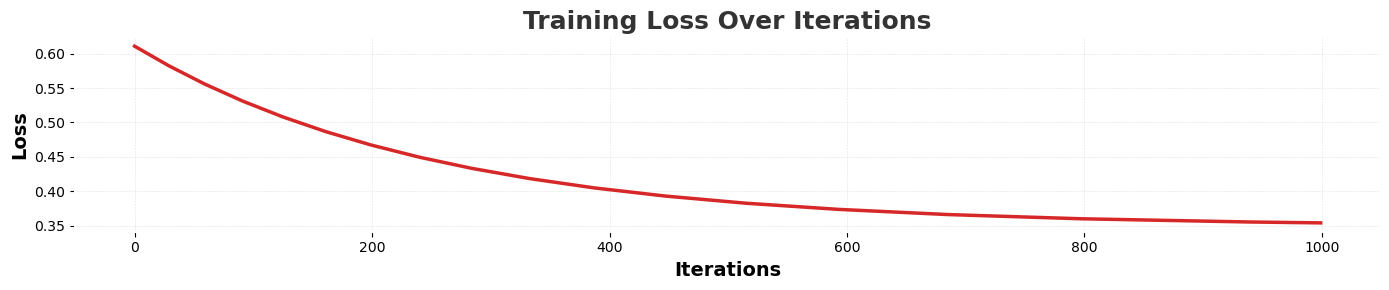

In [32]:
model.plot_loss()

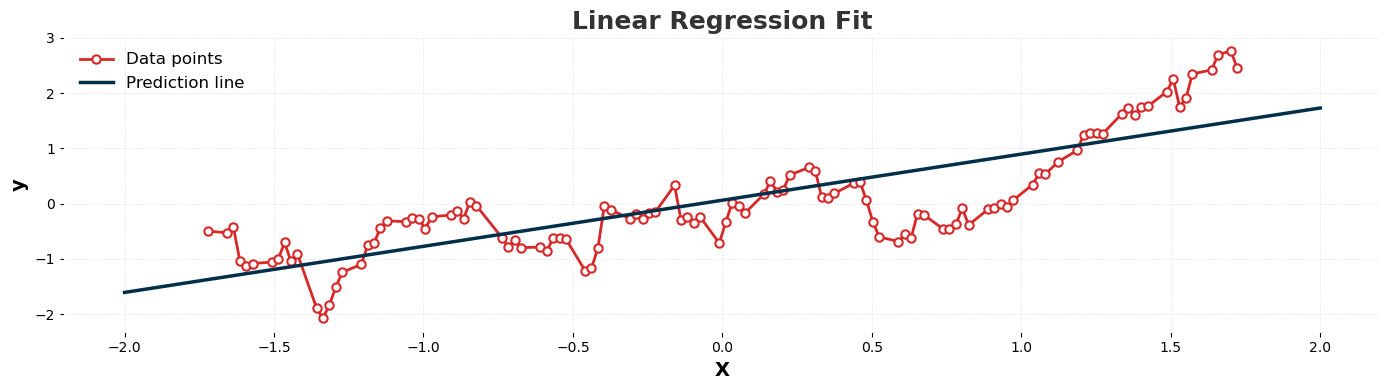

In [33]:
# Prepare data
X_vals = model.X.squeeze().detach().numpy()
y_vals = model.y.squeeze().detach().numpy()

plt.figure(figsize=(14, 4))
plt.plot(
    X_vals, y_vals, 
    color='#D62828',       # Warm red.
    linestyle='-', 
    marker='o', 
    markersize=6, 
    markerfacecolor='white', 
    markeredgewidth=1.5, 
    markeredgecolor='#D62828', 
    label='Data points'
)

# Predict y values at x = -2 and x = 2
x_line = torch.tensor([[-2.0], [2.0]], dtype=model.data_type)
y_line = model.predict(x_line).detach().numpy()

plt.plot(
    [-2, 2], y_line, 
    color='#003049',       # Deep blue
    linewidth=2.5, 
    label='Prediction line'
)

plt.xlabel('X', fontsize=14, weight='bold')
plt.ylabel('y', fontsize=14, weight='bold')
plt.title('Linear Regression Fit', fontsize=18, weight='bold', color='#333333')
plt.legend(frameon=False, fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
model.predict(2.5)

tensor([-1.0576], dtype=torch.float64, grad_fn=<AddBackward0>)